# Unit Testing Optimisation

## Importing the Packages

In [1278]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [1279]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", False)

## Defining SE Covariance

In [1280]:
@jit
def Condition(Exponent):
  return 1455/2 * jnp.tanh(Exponent/2.0) - 18.5

In [1281]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  NewTime = jnp.where(Xarr < Lag, 1000, Xarr - Lag)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [1282]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

In [1283]:
Vec_SE = jit(vmap(vmap(Squared_exp, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

## Creating Test Data

In [1284]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [1285]:
# Time resolution
time_bin = 0.005

### Input Spike Train

In [1286]:
subkeyx = subkeys[-1]

# Time horizon for input data
x_maxt = 2.5

# Maximum index of input data
k = np.floor(x_maxt/time_bin).astype(np.int64)

xtime = np.linspace(0.0, x_maxt, k + 1)

xtest = random.bernoulli(subkeyx, 0.1, (k+1,)).astype(np.float64)

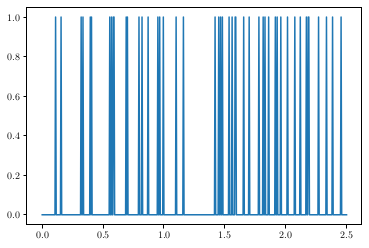

In [1287]:
plt.plot(xtime, xtest)

### True Filter

In [1347]:
subkeyf = subkeys[-2]

# Filter horizon
f_maxt = 0.25

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1)

# Damped frequency
w_d = 35.0

# Sqrt True rise rate
tau_rise = np.sqrt(0.01)

# Sqrt True diff
tau_diff = np.sqrt(0.02)

# True lag
lag = 0.03

env_true = AlpEnvelope(ftime, tau_rise, tau_diff, lag)

# Envelope peak
sqtr = tau_rise ** 2
sqtd = sqtr + tau_diff ** 2
tmax = (np.log(sqtr / sqtd) * sqtd * sqtr) / (sqtr - sqtd)

ftrue = np.sin(w_d * (ftime  - tmax - sqlg + np.pi/(2.0 * w_d))) * env_true

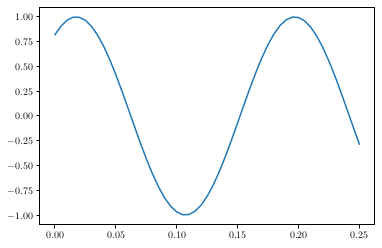

In [1350]:
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

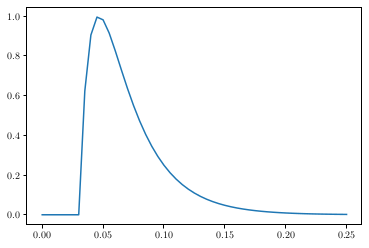

In [1349]:
plt.plot(ftime, env_true)

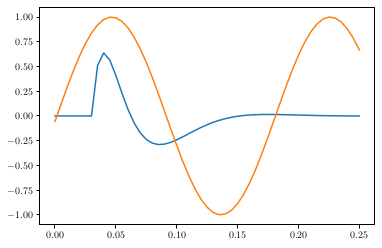

In [1352]:
plt.plot(ftime, ftrue)
plt.plot(ftime, np.sin(w_d * (ftime  - tmax - lag + np.pi/(2.0 * w_d))))

### True Noise

In [1292]:
subkeyn = subkeys[-3]

# True noise variance
sign_true = 0.05

# Noise vector
noise_vec = sign_true * random.normal(subkeyn, (k + 1,))

### Output

In [1293]:
# Padding and applying the FFT
xpad = np.append(xtest, np.zeros(n))
fpad = np.append(ftrue, np.zeros(k))

x_fft = np.fft.rfft(xpad)
f_fft = np.fft.rfft(fpad)

fftmul = x_fft * f_fft

ynonoise = np.fft.irfft(fftmul, n + k + 1)[:k + 1]

ytest = ynonoise + noise_vec
ytime = np.linspace(0.0, x_maxt, k + 1)

In [1294]:
# Showing equals the raw convolution
yffttest = np.convolve(xtest, ftrue)[:k + 1] + noise_vec

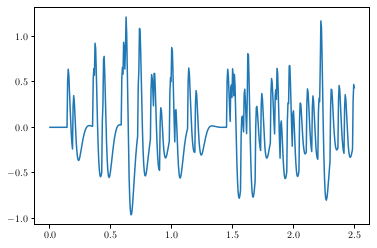

In [1295]:
plt.plot(ytime, ynonoise)

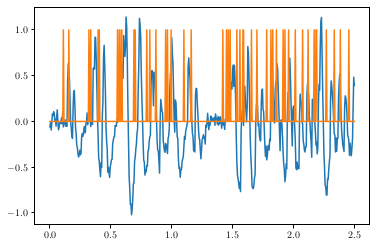

In [1296]:
plt.plot(ytime, ytest)
plt.plot(xtime, xtest)

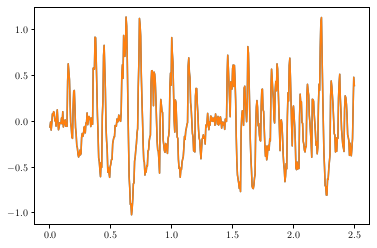

In [1297]:
plt.plot(ytime, yffttest)
plt.plot(ytime, ytest)

## Variational Inference

### ELBO

#### Kl Divergence Term

In [1298]:
@jit
def KL_Term(L_Matrix, V_Vector, M):
  return 0.5 * (- jnp.sum(jnp.log(jnp.diag(L_Matrix) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - M)

#### Log-Likelihood

In [1299]:
@partial(jit, static_argnums = (2, 3, ))
def Log_Likelihood(F_Pad, Sigma_n, N, K, Y_Test, X_Fft):

  F_Fft = jnp.fft.rfft(F_Pad)

  Mean = jnp.fft.irfft(X_Fft * F_Fft, N + K + 1)[: K + 1]
  
  return - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                  jnp.sum((Y_Test - Mean)**2)/(Sigma_n ** 2))

In [1300]:
Vec_LL = jit(vmap(Log_Likelihood, in_axes = [1, None, None, None, None, None]),
             static_argnums = (2,3,))

#### Expected Log-Likelihood

In [1301]:
@partial(jit, static_argnums = range(9,13))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):

  K_MM = Vec_SE(Z_Vector, Z_Vector, Sigma_f, Ell)
  K_MN = Vec_SE(Z_Vector, F_Time, Sigma_f, Ell)
  C = jnp.linalg.cholesky(K_MM + 1e-6 * jnp.eye(M)) 
  K_NN = Vec_SE(F_Time, F_Time, Sigma_f, Ell)
  
  B = jsc.linalg.solve_triangular(C, K_MN, lower = True)

  BT = B.T

  Mu_q = B.T @ V_Vector

  V_q = K_NN + BT @ (L_Matrix @ L_Matrix.T - jnp.eye(M)) @ B

  Chol_Vq = jnp.linalg.cholesky(V_q + 1e-6 * jnp.eye(N + 1))

  F_Samples = (Mu_q + Chol_Vq @ random.normal(Subkey, (N + 1, Number_F))) * AlpEnvelope(F_TimeT, TRise, TauDiff, Lag)

  F_Samples = jnp.vstack((F_Samples, jnp.zeros((K, Number_F))))

  Likelihoods = Vec_LL(F_Samples, Sigma_n, N, K, Y_Test, X_Fft)

  return jnp.mean(Likelihoods)

In [1302]:
test_number_f = 100
test_m = int(1000)
test_key = random.PRNGKey(0)
test_sigma_f = 1.0
test_ell_f = 0.01
test_sigma_n = 0.05
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = np.zeros(test_m).reshape((test_m, 1))
test_l_mm = np.eye(test_m)
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [1303]:
print(Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

-14029.407040123275


#### ELBO

In [1304]:
@partial(jit, static_argnums = range(10, 14))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F,
         M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey):
         
  Lag = Lag ** 2.0

  Square_Frac = Z_Fractions ** 2.0
  Z_Vector = ((Square_Frac) / jnp.max(Square_Frac)) * (F_Time[-1] - Lag) + Lag

  D = jnp.diag(jnp.exp(L_Diag))

  L_Matrix = (D + jnp.zeros((M, M))).at[jnp.tril_indices(M, -1)].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F,
                  M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  
  return (KL-Exp)/(K + 1)

In [1305]:
test_number_f = 100
test_m = 200
test_key = random.PRNGKey(0)
test_sigma_f = 2.0
test_ell_f = 0.7
test_sigma_n = 0.01
test_z_m = np.linspace(0.0, ftime[-1], test_m)
test_v_m = 5.0 * np.ones((test_m, 1))
test_l_diag = np.ones(test_m)
test_l_odiag = np.tril(np.zeros((test_m, test_m)), -1)[np.tril_indices(test_m, -1)]
test_trise = 0.02
test_tdecay = 0.03
test_lag = 0.01

In [1306]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdecay, test_lag, test_number_f, test_m, n, k, ytest, x_fft, ftime, ftime.reshape((n + 1, 1)), test_key))

965.4038200866431


In [1307]:
Grad_Bound = jit(grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 14))

### Optimiser

#### Sub-function Definitions

In [1308]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [1309]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [1310]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [1311]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [1312]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1313]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1314]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [1315]:
@jit
def CAdam(Iter, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Iter = tuple(Iter * jnp.ones(10))
  Mhat = tree_map(MBias, M, Iter) # Bias correction.
  Vhat = tree_map(VBias, V, Iter) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [1316]:
@jit
def MAdam(Iter, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Iter = tuple(Iter * jnp.ones(10))
  Mhat = tree_map(MBias, M, Iter) # Bias correction.
  Vhat = tree_map(VBias, V, Iter) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [1317]:
@jit
def FAdam(Iter, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Iter = tuple(Iter * jnp.ones(10))
  Mhat = tree_map(MBias, M, Iter) # Bias correction.
  Vhat = tree_map(VBias, V, Iter) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [1318]:
@partial(jit, static_argnums = range(10,14))
def _CUpdate(Iter, X, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, Subkey, Key, Num_Coarse_Fs, M, N, K):

  Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)

  return X, Mad, Vad, Subkey, Key

In [1319]:
@partial(jit, static_argnums = range(10,14))
def _MUpdate(Iter, X, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, Subkey, Key, Num_Coarse_Fs, M, N, K):

  Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)

  return X, Mad, Vad, Subkey, Key

In [1320]:
@partial(jit, static_argnums = range(10,14))
def _FUpdate(Iter, X, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, Subkey, Key, Num_Coarse_Fs, M, N, K):

  Grads = Grad_Bound(*X, Num_Coarse_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, Subkey = random.split(Key)

  return X, Mad, Vad, Subkey, Key

#### Adam Function Definition

In [1321]:
def AdamOpt(Init_Params, X_Fft, Y_Test, F_Time, F_TimeT, M, N, K, Num_Fs,              
                        Coarse_Schedule = [400, 400, 700], Mid_Schedule = [5000],
                        Fine_Iters = 5000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = np.zeros(6500)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(1)
  Key, Subkey = random.split(Key)
  Params = Init_Params
  Value = 1e20

  for i in range(len(Coarse_Schedule)):
    if jnp.isnan(Value):
      break
    for j in range(Coarse_Schedule[i]):
      OldParams = Params 
      Params, Mad, Vad, Subkey, Key = _CUpdate(j, Params, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, 
                                                      Subkey, Key, Num_Fs, M, N, K)
                                                     
      Value = Neg_ELBO(*Params, Num_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
      print(Value)
      print(Step)
      if jnp.isnan(Value):
        break
      ELBO_History[Step] = -Value
      Step += 1

  for i in range(len(Mid_Schedule)):
    if jnp.isnan(Value):
      break
    for j in range(Mid_Schedule[i]):
      OldParams = Params
      Params, Mad, Vad, Subkey, Key = _MUpdate(j, Params, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, 
                                                      Subkey, Key, Num_Fs, M, N, K)
      Value = Neg_ELBO(*Params, Num_Fs, M, N, K, Y_Test, X_Fft, F_Time, F_TimeT, Subkey)
      print(Value)
      print(Step)
      if jnp.isnan(Value):
        break
      ELBO_History[Step] = -Value
      Step += 1

  # for i in range(Fine_Iters):
  #   Params, Mad, Vad, Subkey, Key, Value = _FUpdate(i, Params, Mad, Vad, Y_Test, X_Fft, F_Time, F_TimeT, 
  #                                                   Subkey, Key, Num_Fs, M, N, K)
  #   ELBO_History[Step] = -Value
  #   Step += 1

  return OldParams, ELBO_History 

In [1322]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 3.0
iell = 0.0002
isigma_n = 0.00005


itrise = np.sqrt(0.05)
itaudiff = np.sqrt(0.04)
ilag = np.sqrt(0.01)

# Variational parameters
num_ind = 30
iz_fracs = jnp.sqrt(jnp.linspace(0.0, 1.0, num_ind))
key, *subkeys = random.split(key, 4)
iv_vector = (jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-3], (num_ind,))).reshape((num_ind, 1))
il_diag = jnp.zeros(num_ind) + 0.01 * random.normal(subkeys[-2], (num_ind,))
il_odiag = jnp.zeros(int((num_ind ** 2 - num_ind) / 2)) + \
            0.1 * random.normal(subkeys[-1], (int((num_ind ** 2 - num_ind) / 2),))
num_f = 100
ftimet = ftime.reshape((n + 1, 1))

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, opt_subkey = random.split(opt_key)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, n, k, ytest, x_fft, ftime, ftimet)

In [1323]:
fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

120133.83050629783
0
50275.02788960297
1
28297.48605631011
2
26229.517179836756
3
13988.208758149345
4
12126.461512462687
5
9781.741643971693
6
8740.544947504894
7
7472.23600829978
8
5503.234720249362
9
4542.563937566777
10
5254.377478281393
11
4108.660381767138
12
2681.8197904672825
13
4217.811409754391
14
2692.044404648003
15
3284.712270160201
16
2803.3609104185252
17
2804.8785417239
18
2194.327089962473
19
1973.8502634538556
20
1803.8512190202136
21
2130.753230433455
22
1786.2290020592698
23
1472.7366042882113
24
1439.8557566726743
25
1746.3869351369303
26
1613.38825505952
27
1470.8463627234946
28
1123.0046524872685
29
1043.2130748672216
30
1207.1614358736217
31
1510.5389859195784
32
996.8818322494084
33
908.9108617016493
34
1078.9230332303193
35
1025.4806267436811
36
1001.1665625191126
37
856.5427208503129
38
976.4691758400554
39
769.487593916858
40
841.4119962528151
41
933.8264000422731
42
959.7585324880865
43
676.7842462826558
44
692.9208527273105
45
805.5248357158224
46
759.8254

In [1324]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [1325]:
print(Neg_ELBO(*params, num_f, *consparams, opt_subkey))

3973379786.8781977


In [1326]:
print(Neg_ELBO(*fparams, num_f, *consparams, opt_subkey))

-1.5430653063798936


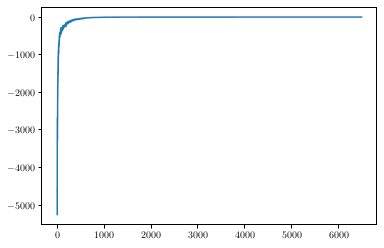

In [1327]:
plt.plot(elbo_history[10:])

In [1328]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [1329]:
flag = flag ** 2
ilag = ilag ** 2

In [1330]:
fv_vector = fv_vector.flatten()
iv_vector = iv_vector.flatten()

In [1331]:
print(fsigma_f)

2.8058441783020913


In [1332]:
print(fell)

-0.0736353853794282


In [1333]:
print(fsigma_n)

0.049216794133555716


In [1334]:
print(ftrise)

0.12605330876709003


In [1335]:
print(ftaudiff)

0.11781746341613548


In [1336]:
print(flag)

0.03006646930004282


In [1337]:
fsquares = fz_fracs ** 2
fz_vector = ((fsquares) / jnp.max(fsquares)) * (ftime[-1] - flag) + flag
isquares = iz_fracs ** 2
iz_vector = ((isquares) / jnp.max(isquares)) * (ftime[-1] - ilag) + ilag

In [1338]:
d = np.diag(np.exp(fl_diag))

fl_matrix = d + np.zeros(num_ind)
fl_matrix[np.tril_indices(num_ind, -1)] = fl_odiag

## Variational Predictions

In [1339]:
fpred_points = ftime.copy()

In [1340]:
ikmm = Vec_SE(iz_vector, iz_vector, isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Vec_SE(iz_vector, fpred_points, isigma_f, iell)
ibast = sc.linalg.solve_triangular(icpred, ikzast, lower = True)
icov_pred = Vec_SE(fpred_points, fpred_points, isigma_f, iell) + \
           ibast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ ibast
imean_pred = iv_vector @ ibast
ienv = AlpEnvelope(ftime, itrise, itaudiff, ilag)
ienvind = AlpEnvelope(iz_vector, itrise, itaudiff, ilag)
imean_pred *= ienv

In [1341]:
kmm = Vec_SE(fz_vector, fz_vector, fsigma_f, fell)
cpred = np.linalg.cholesky(kmm + 1e-6 * np.eye(num_ind))
kzast = Vec_SE(fz_vector, fpred_points, fsigma_f, fell)
bast = sc.linalg.solve_triangular(cpred, kzast, lower = True)
cov_pred = Vec_SE(fpred_points, fpred_points, fsigma_f, fell) + \
           bast.T @ (fl_matrix @ fl_matrix.T - np.eye(num_ind)) @ bast
mean_pred = fv_vector @ bast
fenv = AlpEnvelope(ftime, ftrise, ftaudiff, flag)
fenvind = AlpEnvelope(fz_vector, ftrise, ftaudiff, flag)
mean_pred *= fenv

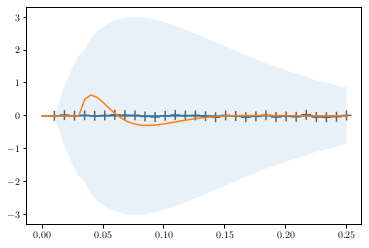

In [1342]:
plt.plot(fpred_points, imean_pred)
plt.plot(ftime, ftrue)
is2 = np.sqrt(np.diag(icov_pred))
ifill = (imean_pred - is2 * ienv, imean_pred + is2 * ienv)
plt.fill_between(fpred_points, *ifill, alpha = 0.1)
plt.scatter(iz_vector, iv_vector @ icpred.T, s = 100, marker = '+', c='k', alpha = 0.6)

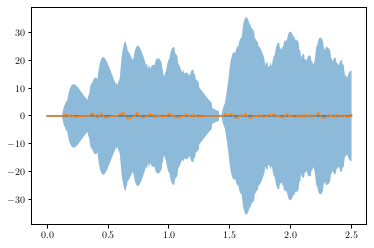

In [1343]:
plt.plot(ytime, np.convolve(xtest, imean_pred)[: k + 1])
plt.plot(ytime, ytest)   
plt.fill_between(ytime, np.convolve(xtest, imean_pred - 2*is2*ienv)[: k + 1] - 2* isigma_n,
                    np.convolve(xtest, imean_pred + 2*is2*ienv)[: k + 1] + 2* isigma_n, alpha = 0.5)                 

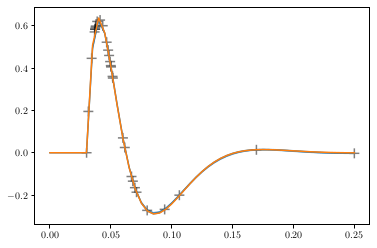

In [1344]:
plt.plot(fpred_points, mean_pred)
plt.plot(ftime, ftrue)
s2 = np.sqrt(np.diag(cov_pred))
fill = (mean_pred - 2*s2*fenv, mean_pred + 2*s2*fenv)
plt.fill_between(fpred_points, *fill, alpha = 0.6)
plt.scatter(fz_vector, (fv_vector @ cpred.T) * fenvind, s = 100, marker = '+', c='k', alpha = 0.5)

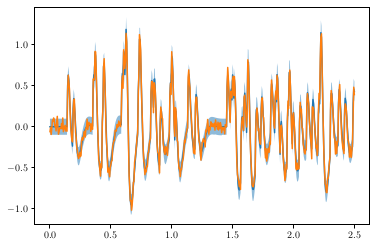

In [1345]:
plt.plot(ytime, np.convolve(xtest, mean_pred)[: k + 1])
plt.plot(ytime, ytest)
plt.fill_between(ytime, np.convolve(xtest, mean_pred - 2*s2*fenv)[: k + 1] - 2* fsigma_n,
                    np.convolve(xtest, mean_pred + 2*s2*fenv)[: k + 1] + 2* fsigma_n, alpha = 0.5)                  